In [1]:
# This is only needed if the notebook is run in VSCode
import nbs_pipeline.utils.vscode  as vs
vs.DisplayHandle.update = vs.update_patch


# OR-ELM: Online Recurrent Extreme Learning Machine for time-series prediction

> This notebook applies visual analytics to [OR_ELM](https://github.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine) algorithm

In [2]:
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!from tchub.all import *
import wandb
wandb_api = wandb.Api()
from fastcore.all import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.schedule import *
from dvats.all import *
import nbs.orelm_torch as orelm

/home/macu/lib/orelm/
El directorio existe: /home/macu/lib/orelm/
['/home/macu/work/nbs_pipeline', '/home/macu/env/lib/python310.zip', '/home/macu/env/lib/python3.10', '/home/macu/env/lib/python3.10/lib-dynload', '', '/home/macu/env/lib/python3.10/site-packages', '/home/macu/env/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/macu/lib/tsai', '/home/macu/work']
['/home/macu/work/nbs_pipeline', '/home/macu/env/lib/python310.zip', '/home/macu/env/lib/python3.10', '/home/macu/env/lib/python3.10/lib-dynload', '', '/home/macu/env/lib/python3.10/site-packages', '/home/macu/env/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/macu/lib/tsai', '/home/macu/work', '/home/macu/lib/orelm/']


For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook, make sure you have the `$WANDB_API_KEY` environment varibale defined with your API_KEY (run in a terminal `echo $WANDB_API_KEY` to see it). If not, run in a terminal `wandb login [API_KEY]`. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account.

## Notebook configuration

In [3]:
import nbs_pipeline.utils.config as cfg
config, job_type, dataSet = cfg.get_artifact_config_ORELM(True)

Current: /home/macu/work/nbs_pipeline
yml: ./config/02c-encoder_orelm.yaml
... About to replace includes with content
Before configuration reading 
-include: None
-user_preferences:
	-use_wandb: False
	-wdb:
		-user: mi-santamaria
		-project_name: test-project
		-version: 0
		-mode: offline
		-artifacts_path: ./data/wandb_artifacts
	-data:
		-folder: ~/data/
		-fname: Semantic_Segmentation_TiltABP
		-ftype: .csv
		-cols: []
		-freq: 1s
	-artifact:
		-alias: TiltABP
	-directories:
		-tmp: tmp
		-data: ~/data/Semantic_Segmentation_TiltABP.csv
-data:
	-name: Semantic_Segmentation_TiltABP
	-path: ~/data/Semantic_Segmentation_TiltABP.csv
	-alias: TiltABP
	-cols: []
	-csv_config:
	-date_offset: None
	-date_format: %Y-%m-%d %H:%M:%S
	-freq: 1s
	-joining_train_test: False
	-missing_values:
		-technique: None
		-constant: None
	-normalize_training: False
	-range_training: None
	-range_testing: None
	-resampling_freq: None
	-start_date: None
	-test_split: None
	-time_col: None
-wandb:
	-user: mi

In [4]:
print("Project: "+config.wandb_project)
run = wandb.init(
    entity          = config.wandb_entity,
    project         = config.wandb_project,
    group           = config.wandb_group,
    job_type        = job_type,
    allow_val_change= True,
    mode            = 'online' if config.use_wandb else 'disabled',
    config          = config,
    resume          = False
)
config = run.config  # Object for storing hyperparameters
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

Project: test-project


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Loading the datasets

In [5]:
print("Used dataSet:")
cfg.recursive_print_attrdict(dataSet)

Used dataSet:
-folder: ~/data/
-fname: Semantic_Segmentation_TiltABP
-ftype: .csv
-cols: []
-freq: 1s


### Sliding window features

$Z$ is a $w \times s \times t$ matrix. The first step consists in slicing the original multivariate time series into slices of shape ($w \times d$), as shown in this figure from the paper.
<img src="https://i.imgur.com/R9Fx8uO.png" style="width:800px;height:400px"/>

The hyperparameters of this sliding window approach are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [6]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])

In [7]:
train_artifact = artifacts_gettr(config.train_artifact)
df_train = train_artifact.to_df()
X_train, _ = sw(df_train) #Windows
df_train.shape, X_train.shape

wandb:   1 of 1 files downloaded.  


((40000, 2), (39969, 2, 32))

In [8]:
df_train.head(5)

,time,abp
1970-01-01 00:00:00,0,6832.0
1970-01-01 00:00:01,1,6928.0
1970-01-01 00:00:02,2,6968.0
1970-01-01 00:00:03,3,6992.0
1970-01-01 00:00:04,4,6980.0


In [9]:
if config.valid_artifact:
    valid_artifact = artifacts_gettr(config.valid_artifact)
    df_val = valid_artifact.to_df()
    X_valid, _ = sw(df_val)
    df_val.shape, X_valid.shape
    print("valid_artifact")
    print(valid_artifact)
    print("df_val")
    print(df_val)
    print("X_valid")
    print(X_valid)
    print("df_val.shape")
    print(df_val.shape)
    print("X_valid.shape")
    print(X_valid.shape)
else:
    print("No validation artifact. Random items to get:", config.valid_size)

No validation artifact. Random items to get: 0.1


## TODO: METER EXPLICACIÓN DE OR-ELM


todo: AQUI VA LA EXPLICACIÓN CON EL EJEMPLO QUE SE META EN EL PAPER

### Create the model

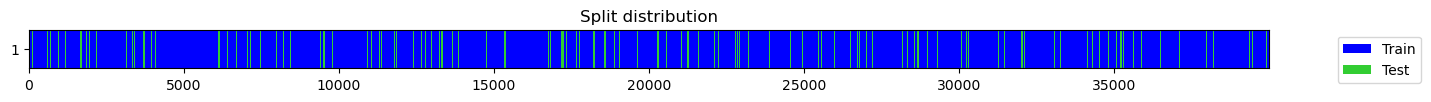

([8470, 33549, 20451, 12666, 39274, 31293, 22061, 27957, 23394, 8642, 241, 12301, 22487, 31239, 15675, 31128, 321, 22292, 12748, 23214, 14816, 32838, 13667, 36646, 25606, 36301, 4956, 35353, 22244, 706, 37636, 8229, 16105, 34313, 22310, 279, 15902, 13228, 24685, 28268, 14003, 1004, 6732, 8465, 9433, 9731, 7461, 30358, 31522, 9800, 1902, 39128, 18069, 37688, 31032, 14231, 38251, 24202, 11499, 10189, 17301, 3319, 15422, 26629, 26269, 13780, 8474, 29318, 22451, 3062, 7024, 39884, 38415, 5756, 33539, 3041, 31938, 12922, 7322, 23753, 8218, 29775, 30967, 39904, 31296, 5712, 11420, 22624, 31220, 20033, 23517, 20278, 512, 1360, 37839, 16323, 23649, 19563, 31892, 25075, 23192, 9770, 32331, 10070, 21283, 19914, 6865, 7526, 152, 15807, 21508, 36756, 12726, 34481, 30419, 194, 33297, 37270, 23707, 32706, 12019, 29907, 20021, 27196, 39034, 9858, 37536, 20638, 31387, 2211, 26112, 12785, 11692, 33677, 24939, 5620, 38671, 25007, 19299, 3436, 20571, 7346, 33271, 21894, 6394, 18771, 24260, 26633, 13059, 

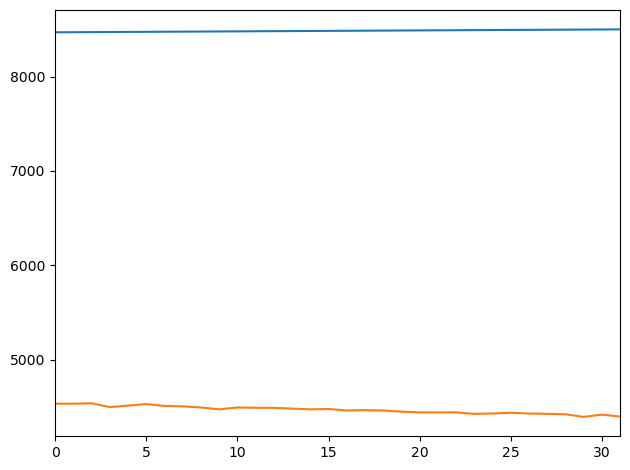

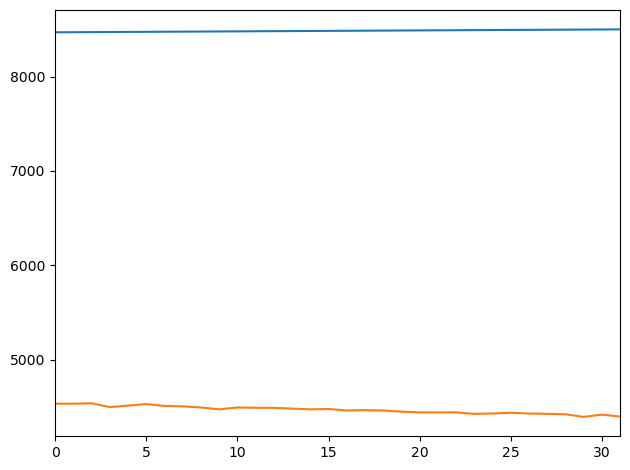

In [10]:
random.seed = config.random_seed

if config.valid_artifact:
    X, y, splits  = combine_split_data(xs=[X_train, X_valid], ys=[X_train, X_valid])
else:
    X = X_train
    y = X_train
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
splits
print(splits)

#Transformations and batch transformations
tfms = [ToFloat(), ToFloat()]
batch_tfms = [TSStandardize(by_sample=True)]
#Get data loaders: Gets time series X and y and the splits used for training a validation. Applies transformations to data before loading
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dls.dataset[0][0].show(), ToTSTensor()(dls.dataset[0][1]).show()

#Create and train the model
features = pd.DataFrame(dls.dataset[0][0])
targets = pd.DataFrame(dls.dataset[0][1]) #1

numLags     = config.epochs
nDimInput   = X_train.shape[2] #numLags
nDimOutput  = targets.shape[1] #1
numNeurons  = nDimInput  #config.numHiddenNeurons
algorithm   = config.algorithm
LN              = config.LN 
AE              = config.AE
InWeightFF      = config.inputWeightForgettingFactor #1.0
OutWeightFF     = config.outputWeightForgettingFactor #0.92
HiddenWeightFF  = config.inputWeightForgettingFactor #1.0
lamb            = config.lamb
predictionStep  = config.stride #5

print("DIMENSIONS:")
print("Inputs shape: " + str(nDimInput))
print("Targets shape: " + str(targets.shape))
print("X_train shape: ", X_train.shape)
print("Input Weights: ("+str(numNeurons)+", " + str(nDimInput)+")")
print("Hidden Weights: ("+str(numNeurons)+", " + str(numNeurons)+")")
print("Hidden A: ("+str(nDimOutput)+", " + str(numNeurons)+")")
print("Bias: (" + str(nDimOutput)+", " + str(numNeurons) +")") #np.random.random((nDimOutput,numNeurons)) * 2 -1
print("Features: (" + str(nDimOutput)+", " + str(nDimInput) +")")


Train the model with fastai Learner class, to abstract from Pytorch's training loop




To track the performance of this model fit, go to the project dashboard in Weights & Biases. The link is provided at the beginning of this notebook, after the execution of the function `wandb.init()'' 

Finally, log the learner to be used by the next notebook in the pipeline

In [11]:
m = orelm.ORELM_torch(
    inputs                      =   nDimInput,
    outputs                     =   nDimOutput,
    numHiddenNeurons            =   config.numHiddenNeurons,
    activationFunction          =   config.activationFunction,
    LN                          =   config.LN,
    AE                          =   config.AE,
    ORTH                        =   config.ORTH,
    inputWeightForgettingFactor =   config.inputWeightForgettingFactor,
    outputWeightForgettingFactor=   config.outputWeightForgettingFactor
)
m.initializePhase(lamb=0.0001)
print(m)

inputs
32
outputs
32
numNeurons
25
Out weight FF
0.92
(25, 32)
--> Initialize_Phase: Input Weights initialized. Shape: (25, 32)
ORELM_torch()


In [18]:
X = []
T = []
for w in X_train:
    #Extract current window
    x, t = w
    X.append(x)
    T.append(t)
X = np.array(X) 
T = np.array(T)
print('Input shape: ', X.shape)
print('Target shape: ', T.shape)
numLags = X_train.shape[1]  #config.epochs
predictions = []
target = []
for i in range (X.shape[0], len(X)-1):
    training_dataset = X[i]
    targets = T[i]
    print("Training["+str(i)+"] shape: " + str(training_dataset.shape))
    print("Targets["+str(i)+"] shape: " + str(targets.shape))
    m.train(training_dataset, targets)
    Y = m.predict(features)
    predictions.append(Y[0][0])
    target.append(y[i][0])
    print (str(i)+"th timeStep -  target: "+str(y[i][0]) + " |    prediction: "+str(predictions[-1]))

Training[0] shape: (2, 32)
Targets[0] shape: (2, 32)
samples = weights: 2 | outputs: 32
Features shape: (2, 32)=> Columns: 2
Weights number: 2 = 2
0th timeStep -  target: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.] |    prediction: 4386.83017038857
Training[1] shape: (2, 32)
Targets[1] shape: (2, 32)
samples = weights: 2 | outputs: 32
Features shape: (2, 32)=> Columns: 2
Weights number: 2 = 2
1th timeStep -  target: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.] |    prediction: 4956.03364337475
Training[2] shape: (2, 32)
Targets[2] shape: (2, 32)
samples = weights: 2 | outputs: 32
Features shape: (2, 32)=> Columns: 2
Weights number: 2 = 2
2th timeStep -  target: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.] |    prediction: 4965.3736

OSELM
encoder_ORELM


ValueError: too many values to unpack (expected 1)

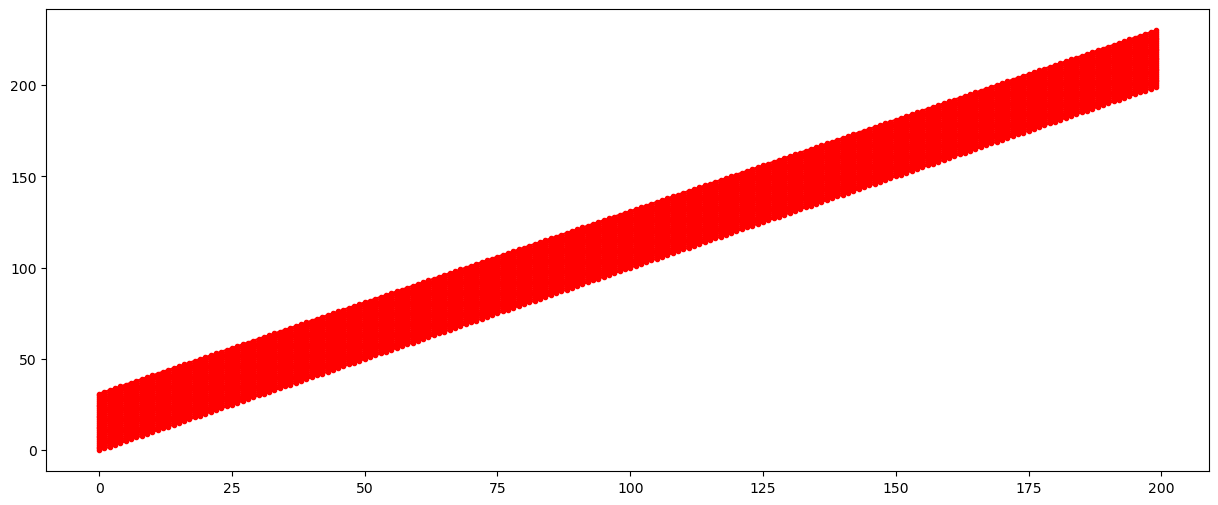

In [22]:

algorithm = config.algorithm
print(algorithm)
print(config.job_type)
plt.figure(figsize=(15,6))

targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([8500,9000])
plt.ylim([0, 30000])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+ config.job_type + ' algorithm: ' + algorithm +' on '+dataSet.fname+' dataset' ,fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.savefig(plot_path,bbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)
print('Prediction plot is saved to'+plot_path)

# Evaluation: Calculate total Normalizedd Root Mean Square Error (NRMSE)

In [ ]:
# Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq
  
def computeSquareDeviation(predictions, truth):
  squareDeviation = np.square(predictions-truth)
  return squareDeviation

# Calculate NRMSE from skip_eval to the end
skip_eval=100
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))

NRMSE 0.19077052758654311


## Plot predictions and target values

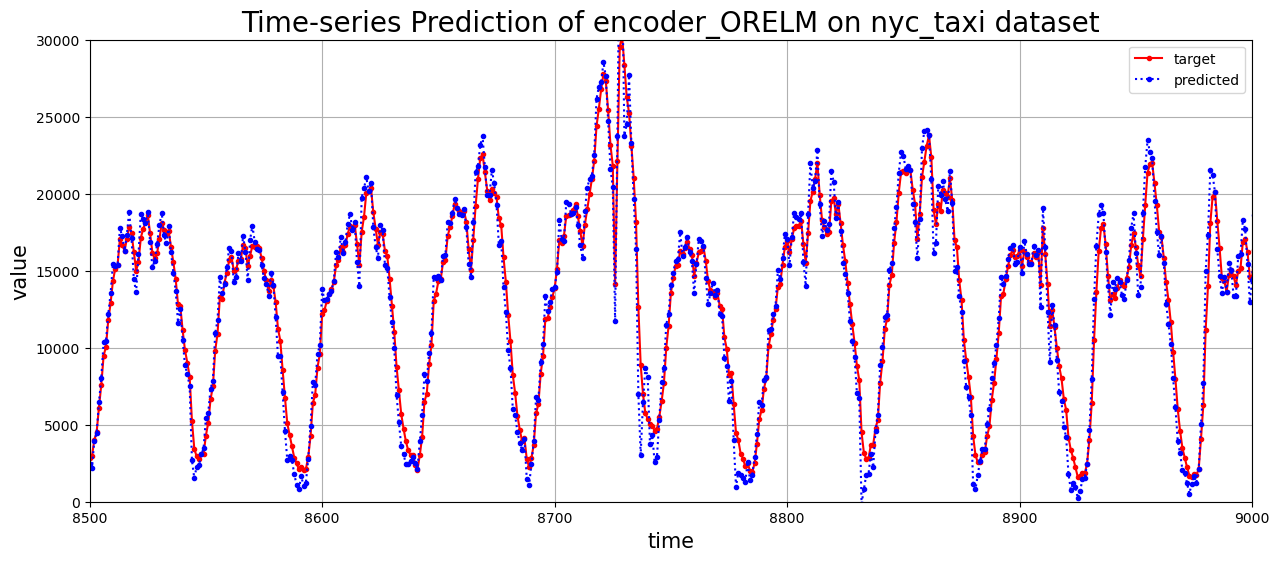

Prediction plot is saved to./predictionPlot.png


In [ ]:
algorithm = config.job_type
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([8500,9000])
plt.ylim([0, 30000])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataSet+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.savefig(plot_path,bbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)
print('Prediction plot is saved to'+plot_path)

## Online learning and prediction of OR-ELM

In [ ]:
run.finish()